In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [25]:
# HYPERPARAMETERS
batch_size = 16
learning_rate = 1e-3
max_iters = 25000
num_epochs = 20

noise_factor = 0.3

In [18]:
transform = transforms.Compose([
    transforms.ToTensor(), # Converts the inputs to tensors, scales the values to [0,1]
])

In [19]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [20]:
# Shuffle train data to break artifical correlations in the original order
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# DO NOT shuffle test data to keep consistency
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
class DenoisingAutoencoder(nn.Module):

    def __init__(self):
        super().__init__()
        # LAYERS
        self.encoder = nn.Sequential(
            # The first Conv2d layer takes a single image
            # It applies 16 different 3x3 kernels with stride 1
            # We add a padding of 1 for the edges (If we had 5x5 kernels, we should use padding of 2)

            # Dim is (B, 1, 28, 28)
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            # Dim is (B, 32, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Dim is (B, 32, 14, 14)
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            # Dim is (B, 16, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Dim is (B, 16, 7, 7)
            # nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            # Dim is (B, 8, 7, 7)
            # nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.decoder = nn.Sequential(
            # nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2),
            # nn.ReLU(),
            # nn.ConvTranspose2d(8, 16, kernel_size=2, stride=2),
            # nn.ReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
            nn.Sigmoid() # End with sigmoid since we want to output numbers in [0,1]
        )
            
    def forward(self, x):
        # Input has dim (B, 28, 28)
        # Values already in range of [0,1] due to how we loaded it
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [22]:
def visualize_grid(tensor):
    grid = make_grid(tensor)

    image = grid.cpu().numpy()

    image = np.transpose(image, (1, 2, 0))

    plt.imshow(image)
    plt.axis('off')
    plt.show

In [23]:
model = DenoisingAutoencoder().to(device)
# model = model.to(device)
loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [24]:
sum(p.numel() for p in model.parameters())

7153

In [26]:
loss_data = []

model.train()
# for i in range(1, max_iters+1):
for epoch in range(num_epochs):
    for batch_idx, (xb, _) in enumerate(train_loader):
        # Move data to device
        xb = xb.to(device)

        # Add noise
        xb_noisy = xb + noise_factor * torch.randn(*xb.shape, device=device)
        xb_noisy = torch.clamp(xb_noisy, min=0, max=1)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(xb_noisy)

        # Calculate loss
        loss = loss_fn(output, xb)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Update loss data
        loss_data.append(loss.item())

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {loss.item():.4f}")

Epoch [1/20] | Loss: 0.0100
Epoch [2/20] | Loss: 0.0097
Epoch [3/20] | Loss: 0.0075
Epoch [4/20] | Loss: 0.0083
Epoch [5/20] | Loss: 0.0064
Epoch [6/20] | Loss: 0.0073
Epoch [7/20] | Loss: 0.0070
Epoch [8/20] | Loss: 0.0082
Epoch [9/20] | Loss: 0.0073
Epoch [10/20] | Loss: 0.0081
Epoch [11/20] | Loss: 0.0075
Epoch [12/20] | Loss: 0.0077
Epoch [13/20] | Loss: 0.0070
Epoch [14/20] | Loss: 0.0064
Epoch [15/20] | Loss: 0.0073
Epoch [16/20] | Loss: 0.0073
Epoch [17/20] | Loss: 0.0073
Epoch [18/20] | Loss: 0.0063
Epoch [19/20] | Loss: 0.0073
Epoch [20/20] | Loss: 0.0075


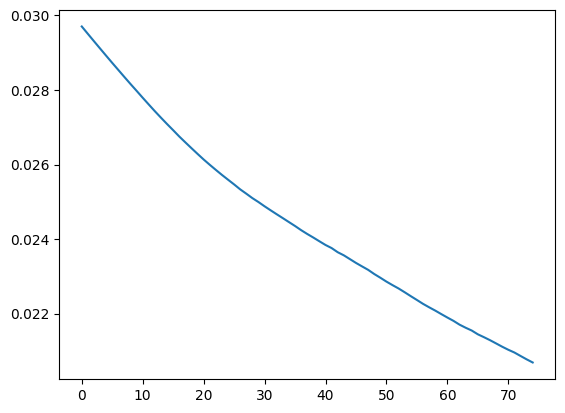

In [27]:
avg_loss_data = [sum(loss_data[i:i+1000])/1000 for i in range(len(loss_data)//1000)]
plt.plot(avg_loss_data)

In [28]:
xb, _ = next(iter(test_loader))
xb = xb.to(device)
xb_noisy = xb + noise_factor * torch.randn((*xb.shape,), device=device)
out = model(xb_noisy)

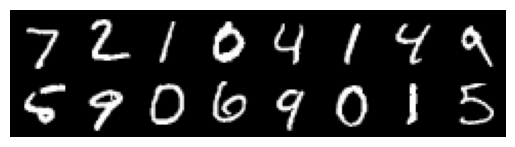

In [29]:
visualize_grid(xb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2100248..1.9380388].


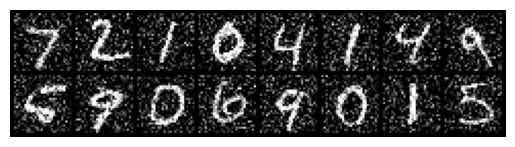

In [30]:
visualize_grid(xb_noisy)

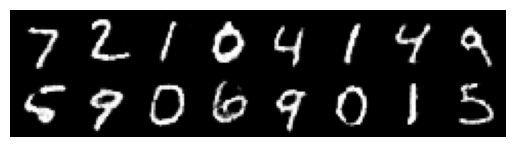

In [31]:
visualize_grid(out)